# Classification

# A. Datasets

* `sklearn.datasets`:
    * `fetch_*` functions such as `fetch_openml()` download real-life datasets.
    * `load_*` functions to load small toy datasets bundled with Scikit-Learn (so they don’t need to be downloaded over the internet).
    * `make_*` functions to generate fake datasets, useful for tests. Generated datasets are usually returned as an (X, y) `tuple` containing the input data and the targets, both as NumPy arrays.
    * Other datasets are returned as `sklearn.utils.Bunch` objects, which are dictionaries whose entries can also be accessed as attributes. They generally contain the following entries:
        * `"DESCR"` : description of the dataset
        * `"data"` : The input data, usually a 2D np array.
        * `"target"` : The labels, usually as a 1D np array.
        
* Some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.


* Datasets returned by `fetch_openml()` are not always shuffled or split
    * The MNIST dataset returned by `fetch_openml()` is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images).

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto') # Flase, to return np arrays
X, y = mnist.data, mnist.target

In [2]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [3]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

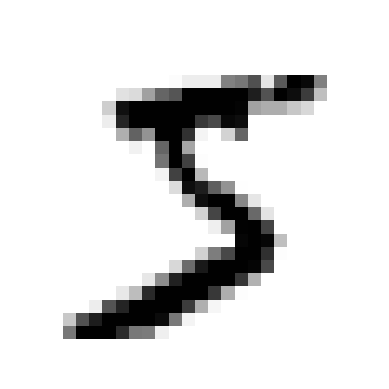

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_digit(image_data, x=28, y=28):
    image = image_data.reshape(x, y)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit);

In [7]:
y[0]

'5'

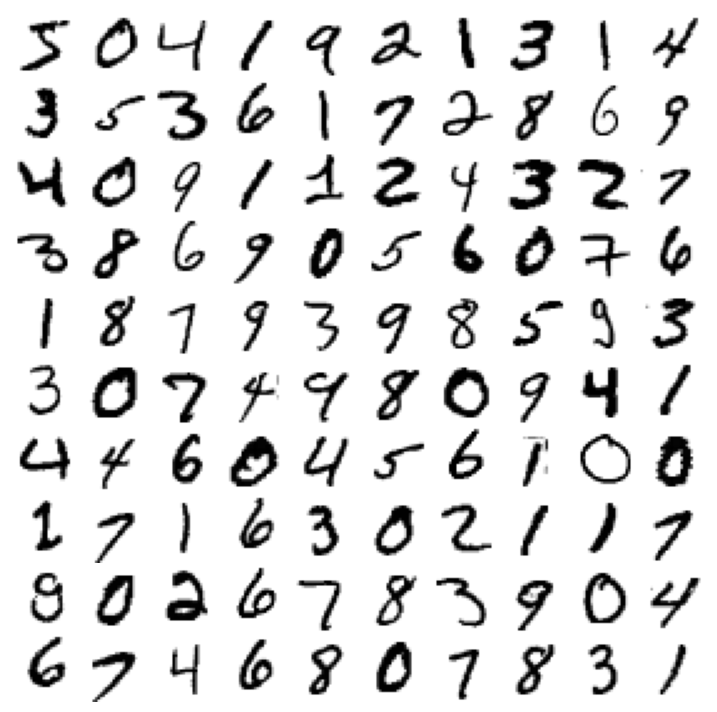

In [8]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0);

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# B. Training a Binary Classifier

* Binary Classifier
    * Classifier for 2 classes.

* A good place to start is with a **stochastic gradient descent (SGD, or stochastic GD)** classifier.
    * Using sklearn's `SGDClassifier` class.
    * This classifier is capable of handling very large datasets efficiently.
    * This is in part because SGD deals with training instances independently, one at a time, which also makes SGD well suited for online learning.
    

In [10]:
# Create target vectors for 5s
y_train_5 = (y_train ==  '5')
y_test_5 = (y_test == '5')

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
# Predict sample 5
sgd_clf.predict([some_digit])

array([ True])

# C. Performance Measures:

### C.1 Measuring Accuracy Using Cross-Validation:

*  A good way to evaluate a model is to use cross-validation:
* `cross_val_score()`:
    * Evaluate our model w/ k-fold cross-validation.
    * **$k$-fold** cross-validation means splitting the training set into $k$ folds, then training the model $k$ times, holding out a different fold each time for evaluation.

* Accuracy is generally not the preferred performance measure for classifiers, especially when dealing w/ *skewed* datasets.
* A much better way to evaluate the performance of a classifier is to look at the confusion matrix (CM).

In [13]:
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state=42)
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
# Test dataset in a dummy classifier
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

print(any(dummy_clf.predict(X_train))) # prints False: no 5s detected

False


In [15]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

##### Implementing Cross-Validation

* Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off the shelf.
* The `StratifiedKFold` class performs stratified sampling to produce folds that contains a representative ratio of each class.
    * At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and make predictions on the test fold.
    * Then it counts the number of correct predictions and outputs the ratio of the correct predictions.

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # add shuffle=True if the dataset is not already shuffled

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]

    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


### C.2. Confusion Matrices:

* The general idea of a confusion matrix is to count the number of times instances of class A are classified as class B, for all A/B pairs.
    * For example, to know the number of times the classifier confused images of 8s with 0s, you would look at row #8, column #0 of the confusion matrix.
    * To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets.
    * You could make predictions on the test set, but it’s best to keep that untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch).
    * Instead, you can use the `cross_val_predict()` function:
        * Performs k-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.
        * This means that you get a *clean prediction* for each instance in the training set (“out-of-sample”: the model makes predictions on data that it never saw during training).

* Each ROW in a cm represents an ACTUAL CLASS, while each COLUMN represents a PREDICTED CLASS.
    <table style="table-layout: auto;">
      <colgroup></colgroup>
      <thead>
        <tr>
          <th rowspan="2", colspan="2">Confusion Matrix</th>
          <th colspan="6">Predicted Class</th>
        </tr>
        <tr>
            <th>negative</th>
            <th>positive</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <th rowspan="2">Actual Class</th>
          <th>NEGATIVE</th>
          <td>True Negative</td>
          <td>False Positive - Type I Error</td>
        </tr>
        <tr>
          <th>POSITIVE</th>
          <td>False Negative - Type II Error</td>
          <td>True Positive</td>
        </tr>
      </tbody>
      
    </table>
      
    * A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right).

* Precision:
  * Accuracy of the POSITIVE predictions $\rightarrow$ **precision of the classifier**.
  * $precision\ =\frac{TP}{TP\ +\ FP}$
  * A trivial way to have perfect precision is to create a classifier that always makes negative predictions, except for one single positive prediction on the instance it’s most confident about.
    * If this one prediction is correct, then the classifier has 100% precision (1/1)
    * Obviously, such a classifier would not be very useful, since it would ignore all but one positive instance.
  * Precision is typically used along w/ another metric named *recall*, also called *sensitivity* or the *True Positive Rate (TPR)*

* Recall (Sensitivity or True Positive Rate, TPR):
  * This is the ratio of POSITIVE instances that are correctly detected by the classifier.
  * $recall\ =\frac{TP}{TP\ +\ FN}$


  




In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### C.3. Precision and Recall:

* It is often convenient to combine precision and recall into a single metric called the $F_1$ score, especially when you need a single metric to compare two classifiers.
* $F_1\ Score$:
    * This is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high $F_1$ score if both recall and precision are high.

* $\Large F_1\ =\ \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2\ *\ \frac{precision\ *\ recall}{precision\ +\ recall}\ = \frac{TP}{TP\ +\ \frac{FN\ +\ FP}{2}} $


* $F_1$ score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.
    * For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection).
    * On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier only has 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### C.4. The Precision/Recall Trade-off:

* How the `SGDClassifier` makes its classification decisions:
    * For each instance, it computes a score based on a decision function.
    * If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.
    * ![Alt text](image-2.png)

* Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions.
    * Instead of calling the classifier’s `predict()` method, you can call its `decision_function()` method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores.
    * `SGDClassifier` uses a threshold equal to 0.

* How to decide w/c threshold to use?
    * First, use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions using the argumen `method="decision_functions"`.
    * With these scores, use `precision_recall_curve()` function to compute precision and recall for all possible thresholds (the function adds a last precision of 0 and a last recall of 1, corresponding to an infinite threshold)
    * Another way to to select a good precision/recall trade-off is to plot precision directly against recall.
    * Suppose you decide to aim for 90% precision. You could use the `precision_recall_curve()` plot (1st plot below) to fiind the threshold you need to use, but that is not very precise.
        * Alternatively, you can search for the lowest threshold that gives you at least 90% precision. For this, you can use the np array's `argmax()` method. This returns the 1st index of the maximum value.

* A high-precision classifier is not very useful if its recall is too low!. For many applications, 48% recall wouldn't be great at all.

In [22]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

''

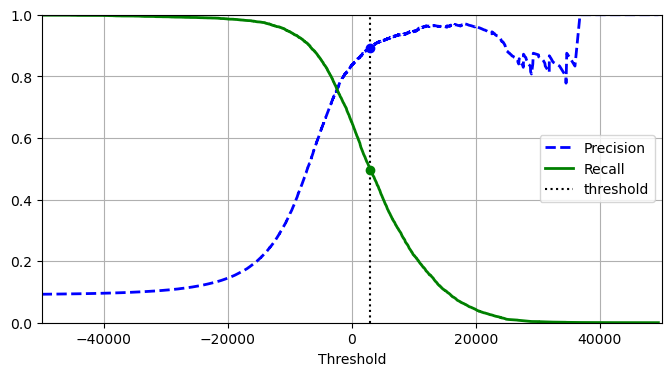

In [23]:
from sklearn.metrics import precision_recall_curve


# return decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
threshold = 3000

plt.figure(figsize=(8, 4))  
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
;

''

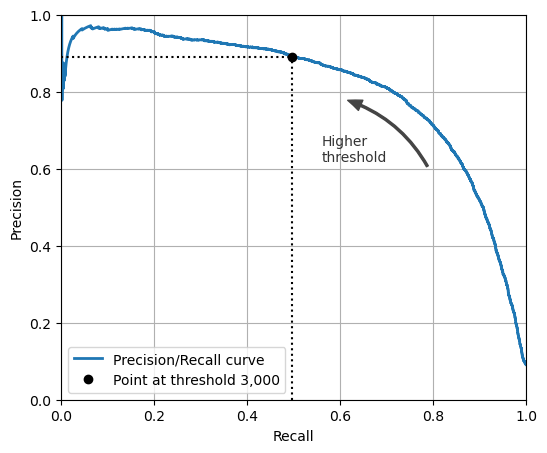

In [24]:
import matplotlib.patches as patches  # for the curved arrow

plt.figure(figsize=(6, 5)) 

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
;

In [25]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [26]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [27]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [28]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### C.5. The ROC Curve:

* Receiver Operating Characteristic (ROC):
    * Another common tool used w/ binary classifiers.
    * Similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (recall) against the false positive rate (FPR).
        * The FPR (fall-out) is the ratio of negative instances that are incorrectly classified as positive. It is equal to $1–TNR$. 
        * The TNR is the ratio of negative instances that are correctly classified as negative. The TNR is also called the *specifity*.
        * Hence, the ROC curve plots sensitivity(recall) versus 1-specifity.

* Use `sklearn.metrics.roc_curve()` function to compute the TPR and FPR for various threshold values.

* Trade-off:
    * The higher the recall (TPR), the more false positives (FPR) the classifier produces. A good classifier stays toward the top-left corner.

* One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to estimate the ROC AUC, `sklearn.metrics.roc_auc_score`

* As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve.
    
* The `sklearn.calibration` package contains tools to calibrate the estimated probabilities and make them much closer to actual probabilities.

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

''

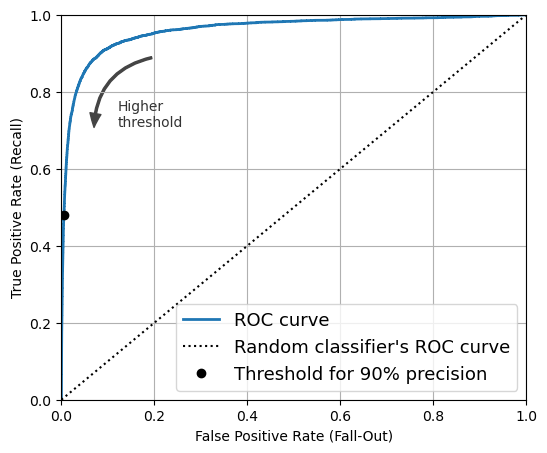

In [30]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5)) 
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
;

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [32]:
# Compare SGDClassifier vs RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [33]:
# Use predict_proba since random forest does not have a decision function
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [34]:
y_probas_forest.shape

(60000, 2)

''

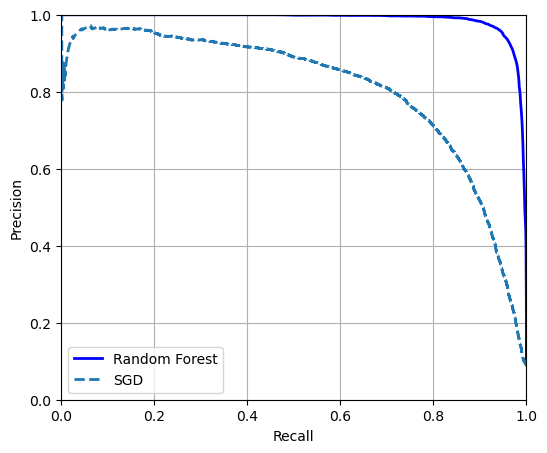

In [35]:
# The The second column contains the estimated probabilities for the positive class

y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

# Plot the PR Curve
plt.figure(figsize=(6, 5))
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
;

In [36]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [38]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [39]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

# D. Multiclass Classification:

* Multiclass / Multinomial Classifiers can distinguish between more than 2 classes.
* Some Scikit-Learn classifiers (e.g., `LogisticRegression`, `RandomForestClassifier`, and `GaussianNB`) are capable of handling multiple classes natively. Others are strictly binary classifiers (e.g., `SGDClassifier` and `SVC`). However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.

* **One-versus-the-rest (OvR) or One-versus-all (OvA)** Strategy:
    * One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score.

* **One-versus-one (OvO)** Strategy:
    * Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. f there are N classes, you need to train $N\ ×\ \frac{(N–1)}{2}$ classifiers.
    * For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels.
    * The main advantage of OvO is that each classifier only needs to be trained on the part of the training set containing the two classes that it must distinguish.
    * Some algorithms (such as support vector machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.

* Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm.

* `.decision_function()`:
    * This method will return the scores per instance: one per class. Each class gets a score equal to the number of won duels plus or minus a small tweak ($max \pm 0.33$) to break ties, based on the classifier scores.

* When a classifier is trained, it stores the list of target classes in its `classes_` attribute, ordered by value.

* To force Scikit-Learn to use one-versus-one or one-versus-the-rest, use the `OneVsOneClassifier` or `OneVsRestClassifier` classes.
    * Create an instance and pass a classifier to its constructor.

In [40]:
# OvO
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [41]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

In [42]:
class_id = some_digit_scores.argmax()
svm_clf.classes_[class_id]

'5'

In [43]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [46]:
len(ovr_clf.estimators_)

10

In [47]:
# Using stochastic gradient descent classifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sgd_clf = SGDClassifier(random_state=42)

X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# E. Error Analysis:

*  One way of improving a model is to analyze the type of errors it makes.
    * Look at the confusion matrix. Make predictions using `cross_val_predict()` function; then pass the labels and predictions to the `confusion_matrix()` function.
    * One option to plot a colored diagram of consfusion matrix is using the `ConfusionMatrixDisplay.from_predictions()` function.

* If there are more errors on a specific class or there are fewer class in the dataset than the other classes, **it is important to normalize the confusion matrix by dividing each value by the total number of data in the corresponding(true) class(i.e., divide by the row's sum)**. 
    * This can be done by setting `normalize="true"`.
    * If you want to make the errors stand out more, you can try putting zero weight on the correct predictions.
    * To normalize the confusion matrix by column rather than by row: set `normalize="pred"`.

* Analyzing the confusion matrix often gives you insights into ways to improve your classifier.
* Analyzing individual errors can also be a good way to gain insights into what your classifier is doing and why it is failing.

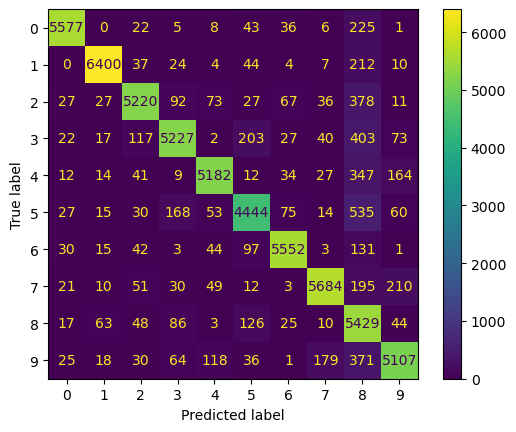

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

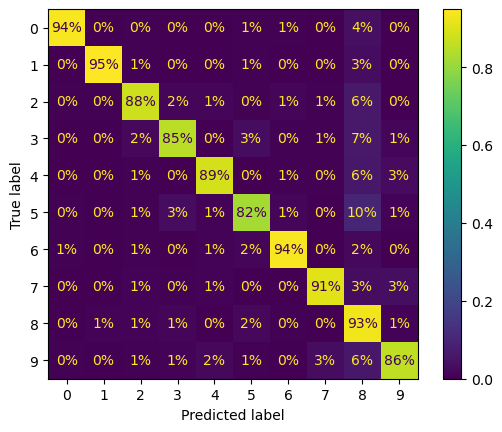

In [49]:
# CM Normalized by ROW
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")

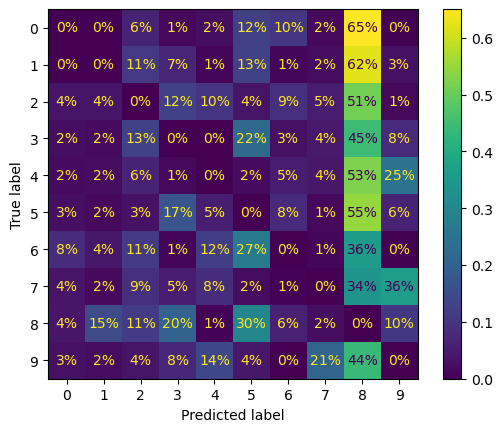

In [50]:
# Errors Normalized by ROW
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%")

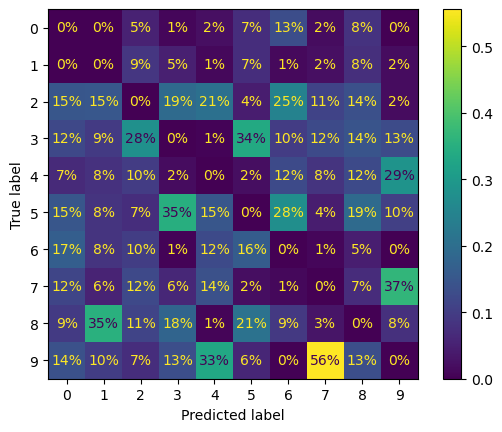

In [51]:
# Errors normalized by column
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")

# F. Multilabel Classification:

* Multilabel classification : 
    * A classification system that outputs multiple binary tags.
* In some cases you may want your classifier to output multiple classes for each instance.
    * Consider a face-recognition classifier: what should it do if it recognizes several people in the same picture? It should attach one tag per person it recognizes.

* There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on the project.
    * One approach is to measure the $F_1`$score for each individual label(or any other binary classifier), then simply compute the average score.
        * This approach assumes that all labels are equally important.

In [52]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

"""
Create two target labels : digits >= 7 and digits whether is odd or even.
"""


y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [53]:
knn_clf.predict([some_digit]) # sample: 5

array([[False,  True]])

In [54]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [55]:
# computes the average F1 score across all labels
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605